In [44]:
import QuantLib as ql

# Set evaluation date
calendar = ql.TARGET()
evaluation_date = ql.Date(7, 11, 2025)
ql.Settings.instance().evaluationDate = evaluation_date

# Bond parameters
issue_date = ql.Date(7, 11, 2020)
maturity_date = ql.Date(7, 11, 2030)  # 10-year bond
face_value = 100
coupon_rate = 0.05  # 5%
coupon_frequency = ql.Annual

# Schedule for coupon payments
schedule = ql.Schedule(issue_date,
                       maturity_date,
                       ql.Period(coupon_frequency),
                       calendar,
                       ql.Unadjusted,
                       ql.Unadjusted,
                       ql.DateGeneration.Backward,
                       False)

# Construct fixed rate bond
bond = ql.FixedRateBond(
    settlementDays=2,
    faceAmount=face_value,
    schedule=schedule,
    coupons=[coupon_rate],
    paymentDayCounter=ql.ActualActual(ql.ActualActual.ISMA))

# Flat yield curve of 4% to discount bond cashflows
flat_rate = ql.SimpleQuote(0.04)
yield_curve = ql.FlatForward(evaluation_date,
                            ql.QuoteHandle(flat_rate),
                            ql.ActualActual(ql.ActualActual.ISMA))
discount_curve = ql.YieldTermStructureHandle(yield_curve)

# Pricing engine
bond.setPricingEngine(ql.DiscountingBondEngine(discount_curve))

# Calculate clean price of the bond
price = bond.cleanPrice()
print(f"The clean price of the bond is: {price:.2f}")


The clean price of the bond is: 104.07


In [53]:
import QuantLib as ql

# Set evaluation date
calc_date = ql.Date(7, 11, 2025)
ql.Settings.instance().evaluationDate = calc_date

# Bond parameters
issue_date = ql.Date(7, 11, 2020)
maturity_date = ql.Date(7, 11, 2030)
settlement_days = 3
face_amount = 100.0
coupons = [0.05]  # 5% coupon rate
day_count = ql.ActualActual(ql.ActualActual.ISMA)

# Conversion details
conversion_price = 50.0
conversion_ratio = face_amount / conversion_price

# Define exercise (American style)
exercise = ql.AmericanExercise(calc_date, maturity_date)

# Empty callability schedule (no callability)
callability_schedule = []

# Coupon payment schedule
schedule = ql.Schedule(issue_date, maturity_date,
                       ql.Period(ql.Annual), ql.TARGET(),
                       ql.Unadjusted, ql.Unadjusted,
                       ql.DateGeneration.Backward, False)

# Construct convertible fixed coupon bond
convertible_bond = ql.ConvertibleFixedCouponBond(
    exercise,
    conversion_ratio,
    callability_schedule,
    issue_date,
    settlement_days,
    coupons,
    day_count,
    schedule,
    face_amount
)

# Underlying equity process parameters
spot_price = 55.0
dividend_yield = 0.02
risk_free_rate = 0.03
volatility = 0.25

spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calc_date, dividend_yield, day_count))
risk_free_ts = ql.YieldTermStructureHandle(ql.FlatForward(calc_date, risk_free_rate, day_count))
volatility_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calc_date, ql.TARGET(), volatility, day_count))

bsm_process = ql.BlackScholesMertonProcess(
    spot_handle, dividend_ts, risk_free_ts, volatility_ts
)

# Credit spread for convertible bond (e.g., 1%)
credit_spread_quote = ql.SimpleQuote(0.01)
credit_spread_handle = ql.QuoteHandle(credit_spread_quote)

# Pricing engine using Cox-Ross-Rubinstein binomial tree, 1000 steps
engine = ql.BinomialConvertibleEngine(bsm_process, "crr", 1000, credit_spread_handle)
convertible_bond.setPricingEngine(engine)

# Calculate and print price (NPV)
price = convertible_bond.NPV()
print(f"Convertible bond price: {price:.2f}")


Convertible bond price: 132.81


In [17]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Parameters
S0 = 55.0           # Initial stock price
K = 50.0            # Conversion price
face_value = 100.0
coupon_rate = 0.05
risk_free_rate = 0.03
volatility = 0.25
dividend_yield = 0.02
maturity = 5        # years
num_paths = 100000
steps_per_year = 50
num_steps = maturity * steps_per_year
dt = 1 / steps_per_year

# Discount factor per step
df = np.exp(-risk_free_rate * dt)

# Simulate GBM paths under risk-neutral measure
np.random.seed(44)
Z = np.random.normal(size=(num_paths, num_steps))
S = np.zeros_like(Z)
S[:, 0] = S0
for t in range(1, num_steps):
    S[:, t] = S[:, t-1] * np.exp((risk_free_rate - dividend_yield - 0.5 * volatility**2)*dt + volatility*np.sqrt(dt)*Z[:, t])

# Initialize cash flows matrix: coupons at coupon payments, face value at maturity
cash_flows = np.zeros_like(S)
coupon_frequency = int(steps_per_year)  # annual coupon
for t in range(coupon_frequency, num_steps+1, coupon_frequency):
    if t < num_steps:
        cash_flows[:, t-1] += coupon_rate * face_value * dt * coupon_frequency
cash_flows[:, -1] += face_value

# Initialize option values at maturity: conversion or redemption
option_values = np.maximum((S[:, -1] / K) * face_value, cash_flows[:, -1])

# Backward induction for LSM
for t in range(num_steps - 2, -1, -1):
    # Discount option values one step back
    option_values *= df
    # Add coupon if coupon date
    if (t+1) % coupon_frequency == 0:
        option_values += coupon_rate * face_value * dt * coupon_frequency
    # In-the-money paths where conversion is attractive
    itm = S[:, t] > K
    if np.any(itm):
        # Regression on state variables (stock price)
        X = S[itm, t]
        Y = option_values[itm]
        # Use polynomial basis for regression
        poly = Polynomial.fit(X, Y, 2)
        continuation_values = poly(S[itm, t])
        # Decide whether to convert or hold
        convert_payoff = (S[itm, t] / K) * face_value
        exercise = convert_payoff > continuation_values
        option_values[itm] = np.where(exercise, convert_payoff, option_values[itm])

print(f"LSM Convertible Bond Price Estimate: {np.mean(option_values):.2f}")


LSM Convertible Bond Price Estimate: 133.01


/Users/rongzhaoou/PyCharmMiscProject/.venv/lib/python3.14/site-packages/numpy/polynomial/polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


In [18]:
import QuantLib as ql
import prettytable as pt

# ----- SPECIFICATIONS -----
issue_date = ql.Date(7, 11, 2020)
maturity_date = ql.Date(7, 11, 2030)
settlement_days = 3
redemption = 100.0         # face amount
coupon_rate = 0.05         # 5% coupon, annual, fixed
coupons = [coupon_rate]
bondDayCount = ql.ActualActual(ql.ActualActual.ISMA)
frequency = ql.Annual

conversion_price = 50.0
conversion_ratio = redemption / conversion_price

underlying = 55.0          # Spot price of stock
spreadRate = 0.01          # Credit spread
dividendYield = 0.02
riskFreeRate = 0.03
volatility = 0.25
timeSteps = 801

# Dates/schedules
calendar = ql.TARGET()
today = ql.Date(7, 11, 2025)
ql.Settings.instance().evaluationDate = today

settlementDate = calendar.advance(today, settlement_days, ql.Days)
exerciseDate = maturity_date
convention = ql.ModifiedFollowing

schedule = ql.Schedule(
    issue_date, maturity_date, ql.Period(frequency), calendar,
    convention, convention, ql.DateGeneration.Backward, False
)

callability = ql.CallabilitySchedule()
# Example of callable: years, price pairs
# callYears = [2, 4]
# callPrices = [101.5, 100.85]
# for i in range(len(callYears)):
#     callability.push_back(
#         ql.SoftCallability(
#             ql.BondPrice(callPrices[i], ql.BondPrice.Clean),
#             schedule[callYears[i]],
#             1.20))
#
# putYears = [3]
# putPrices = [105.0]
# for i in range(len(putYears)):
#     callability.push_back(
#         ql.Callability(
#             ql.BondPrice(putPrices[i], ql.BondPrice.Clean),
#             ql.Callability.Put,
#             schedule[putYears[i]]))

# Exercise types
euro_exercise = ql.EuropeanExercise(exerciseDate)
am_exercise = ql.AmericanExercise(settlementDate, exerciseDate)

# Underlying stock process
dayCounter = ql.Actual365Fixed()
underlyingH = ql.QuoteHandle(ql.SimpleQuote(underlying))
flatTermStructure = ql.YieldTermStructureHandle(
    ql.FlatForward(settlementDate, riskFreeRate, dayCounter))
flatDividendTS = ql.YieldTermStructureHandle(
    ql.FlatForward(settlementDate, dividendYield, dayCounter))
flatVolTS = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(settlementDate, calendar, volatility, dayCounter))
stochasticProcess = ql.BlackScholesMertonProcess(
    underlyingH, flatDividendTS, flatTermStructure, flatVolTS)

# Convertible Bond, European and American
europeanBond = ql.ConvertibleFixedCouponBond(
    euro_exercise, conversion_ratio, callability,
    issue_date, settlement_days, coupons, bondDayCount, schedule, redemption)

americanBond = ql.ConvertibleFixedCouponBond(
    am_exercise, conversion_ratio, callability,
    issue_date, settlement_days, coupons, bondDayCount, schedule, redemption)

tab = pt.PrettyTable(["Tree type", "European", "American"])
tab.float_format = '.6'
tab.align = 'l'

print('=' * 56)
print("Tsiveriotis-Fernandes method")
print('=' * 56)

creditSpreadHandle = ql.QuoteHandle(ql.SimpleQuote(spreadRate))

engine = ql.BinomialJRConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Jarrow-Rudd", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialCRRConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Cox-Ross-Rubinstein", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialEQPConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Additive equiprobabilities", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialTrigeorgisConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Trigeorgis", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialTianConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Tian", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialLRConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Leisen-Reimer", europeanBond.NPV(), americanBond.NPV()])

engine = ql.BinomialJ4ConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
europeanBond.setPricingEngine(engine)
americanBond.setPricingEngine(engine)
tab.add_row(["Joshi", europeanBond.NPV(), americanBond.NPV()])

print(tab)


Tsiveriotis-Fernandes method
+----------------------------+------------+------------+
| Tree type                  | European   | American   |
+----------------------------+------------+------------+
| Jarrow-Rudd                | 131.672705 | 132.806915 |
| Cox-Ross-Rubinstein        | 131.735012 | 132.794629 |
| Additive equiprobabilities | 131.807527 | 132.931815 |
| Trigeorgis                 | 131.735932 | 132.795484 |
| Tian                       | 131.700541 | 132.773482 |
| Leisen-Reimer              | 131.795947 | 132.840456 |
| Joshi                      | 131.795949 | 132.840458 |
+----------------------------+------------+------------+


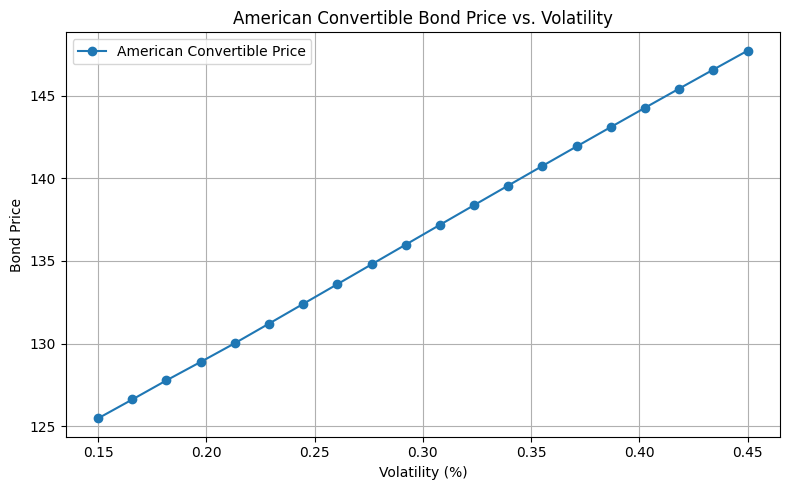

In [12]:
import QuantLib as ql
import prettytable as pt
import matplotlib.pyplot as plt
import numpy as np

# ---- (All your previous specification/block above: parameter setup, bond creation, etc) ----

vols = np.linspace(0.15, 0.45, 20)  # Volatility grid from 5% to 60%
amer_prices = []

for v in vols:
    # update volatility term structure
    flatVolTS = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(settlementDate, calendar, v, dayCounter))
    stochasticProcess = ql.BlackScholesMertonProcess(
        underlyingH, flatDividendTS, flatTermStructure, flatVolTS)
    # Use CRR engine or any other Binomial engine
    engine = ql.BinomialCRRConvertibleEngine(stochasticProcess, timeSteps, creditSpreadHandle)
    americanBond.setPricingEngine(engine)
    amer_prices.append(americanBond.NPV())

plt.figure(figsize=(8,5))
plt.plot(vols, amer_prices, marker='o', label='American Convertible Price')
plt.xlabel("Volatility (%)")
plt.ylabel("Bond Price")
plt.title("American Convertible Bond Price vs. Volatility")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
